In [4]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy as dc

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

from utils.indicator_ops import calculate_bollinger_bands, calculate_ema, calculate_macd, calculate_rsi
from utils.field_processing import create_ts_from_df, create_extra_featurres, create_sequences, create_indicators_features, processing_before_prediction

from utils.dataset import TreadingDataset

In [5]:
SEQUENCE_LENGTH = 9
SHIFT_SIZE = 3
BATCH_SIZE = 32

# Loading the Dataframe

In [11]:
df = pd.read_csv('../../EURUSD_H1_202403_2025.csv', sep='\t')
df.tail()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
6256,2025.03.05,08:00:00,1.06312,1.06390,1.06241,1.06321,2728,0,2
6257,2025.03.05,09:00:00,1.06325,1.06766,1.06295,1.06739,5718,0,1
6258,2025.03.05,10:00:00,1.06736,1.06998,1.06585,1.06982,6590,0,1
6259,2025.03.05,11:00:00,1.06977,1.07222,1.06955,1.07115,5860,0,1
6260,2025.03.05,12:00:00,1.07116,1.07150,1.06834,1.06915,3870,0,1


In [12]:
df.rename(columns={
    '<OPEN>': 'OPEN', 
    '<HIGH>': 'HIGH', 
    '<LOW>': 'LOW', 
    '<CLOSE>': 'CLOSE'
}, inplace=True)
df.tail()

,<DATE>,<TIME>,OPEN,HIGH,LOW,CLOSE,<TICKVOL>,<VOL>,<SPREAD>
6256,2025.03.05,08:00:00,1.06312,1.06390,1.06241,1.06321,2728,0,2
6257,2025.03.05,09:00:00,1.06325,1.06766,1.06295,1.06739,5718,0,1
6258,2025.03.05,10:00:00,1.06736,1.06998,1.06585,1.06982,6590,0,1
6259,2025.03.05,11:00:00,1.06977,1.07222,1.06955,1.07115,5860,0,1
6260,2025.03.05,12:00:00,1.07116,1.07150,1.06834,1.06915,3870,0,1


In [14]:
ts = create_ts_from_df(df, '<DATE>', '<TIME>', 'DATETIME')
new_ts = ts[['CLOSE']]
new_ts.tail()

,CLOSE
DATETIME,
2025-03-05 08:00:00,1.06321
2025-03-05 09:00:00,1.06739
2025-03-05 10:00:00,1.06982
2025-03-05 11:00:00,1.07115
2025-03-05 12:00:00,1.06915


# Feature Engineering

### Créations des colonnes avec les valeurs prix de cloture décalées de 24h __Xi = (X[t - i])__

In [15]:
dataset = TreadingDataset(ts[['CLOSE']])
dataset.prepare_data()

/Users/stephcyrille/Trading/notebooks/forex/../../utils/dataset.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[indicator_field_name] = self.df[close_field].ewm(span=span, adjust=False).mean()
/Users/stephcyrille/Trading/notebooks/forex/../../utils/dataset.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[indicator_field_name] = 100 - (100 / (1 + rs))
/Users/stephcyrille/Trading/notebooks/forex/../../utils/dataset.py:153: SettingWithCopyWarning: 
A value is trying to be set on a co

# Préparation des données de modélisation

In [17]:
X, y = dataset.feature_sequence, dataset.target_sequence

In [19]:
X, y = np.array(X), np.array(y)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Compilation du modèle

In [20]:
lstm_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),    
    # LSTM(30, return_sequences=True),
    LSTM(512),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])


lstm_model.compile(
    optimizer=Adam(learning_rate=0.0001, weight_decay = 1e-5),
    loss='mse'
)
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 512)            │     1,099,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103,889 (4.21 MB)

 Trainable params: 1,103,889 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

### Apprentissage

In [21]:
# Entraînement du modèle
history = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=100, 
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - loss: 0.0235 - val_loss: 9.6705e-04
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - loss: 3.7509e-04 - val_loss: 7.6899e-04
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 2.9610e-04 - val_loss: 6.3950e-04
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 3.0411e-04 - val_loss: 6.2572e-04
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 2.8088e-04 - val_loss: 5.5881e-04
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 2.8348e-04 - val_loss: 5.6983e-04
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 2.3487e-04 - val_loss: 5.3535e-04
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 2.4947e-04 - val_loss: 5.1322e-04
Epoch 9/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 2.2055e-04 - val_loss: 4.8103e-04
Epoch 10/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 2.3073e-04 - val_loss: 5.4779e-04
Epoch 11/100
155/155 ━━━━━━━━━━━

## Evaluation du modèle

### Courbe d'apprentissage

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


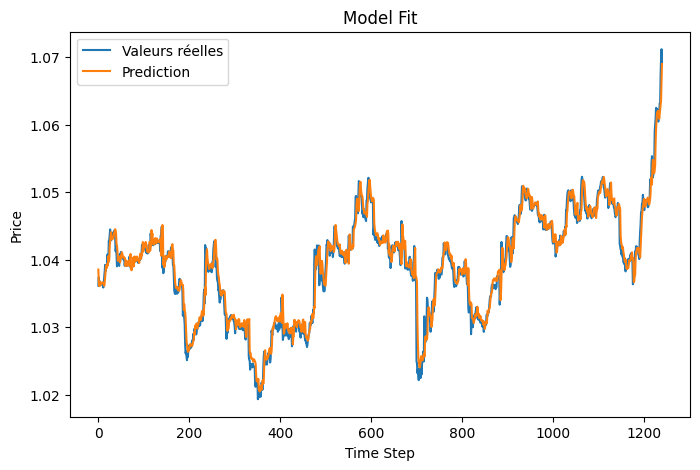

In [ ]:
# Prédiction sur les données de test
predictions = history.model.predict(X_test)
predictions = dataset.target_scaler.inverse_transform(predictions)  # Inverser la normalisation

# Comparaison des prédictions avec les vraies valeurs
y_test_actual = dataset.target_scaler.inverse_transform(y_test.reshape(-1, 1))

#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Prediction vs Actual')
plt.xlabel('Hours')
plt.ylabel('Price')
plt.plot(y_test_actual,label = "Actual close")
plt.plot(predictions,label="Predicted close")
plt.legend()
plt.show()

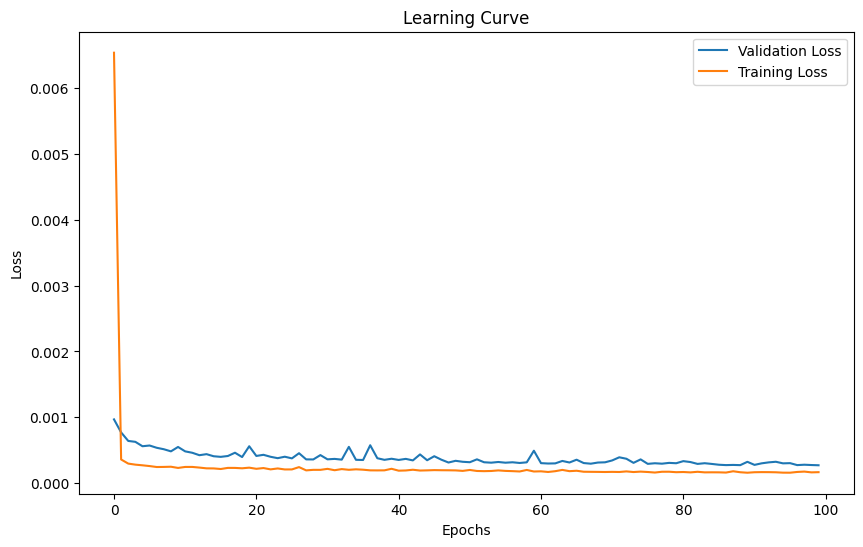

In [23]:
# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Metriques d'évaluation

In [24]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# R2
print('RSquared : ', '{:.2%}'.format(r2_score(y_test_actual, predictions)))

Mean Squared Error: 2.7586455806456728e-06
Mean Absolute Error: 0.0011259016230949735
Root Mean Squared Error: 0.0016609170902383034
RSquared :  95.55%


## Sauvegarde du model

In [26]:
# history.model.save('../../models/test/best_model_EURUSD.keras')
# print('Model saved!!')

In [34]:
ts.to_csv('../../notebooks/inference/datasets/eur_usd_2024_03_2025.csv', index=True)

## Inférence

### Prédiction de la prochaine valeur

In [35]:
# Utiliser les dernières séquences pour prédire le prochain prix
last_seq_df = df_scaled.drop(columns=['CLOSE'])
last_sequence = X[-1]
last_sequence = last_sequence.reshape((1, SEQUENCE_LENGTH, last_sequence.shape[1]))

# Prédiction
predicted_price_scaled = history.model.predict(last_sequence)
predicted_price = scaler_target.inverse_transform(predicted_price_scaled)
print(f"Le prix de clôture prédit pour l'heure suivante est : {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Le prix de clôture prédit pour l'heure suivante est : 1.0491446256637573


### Ajout de la valeur au prochain Timeframe

In [36]:
# Optionnel : Ajouter la prédiction au dataset
next_timestamp = ts.index[-1] + pd.Timedelta(hours=1)  # Supposons des données horaires
new_row = pd.DataFrame({'CLOSE': predicted_price[0][0]}, index=[next_timestamp])
data = pd.concat([ts['CLOSE'], new_row])
data.tail()

,CLOSE
2025-03-03 18:00:00,1.049590
2025-03-03 19:00:00,1.049020
2025-03-03 20:00:00,1.048690
2025-03-03 21:00:00,1.048930
2025-03-03 22:00:00,1.049145


# Pipeline Prediction 

In [37]:
# Base df 
base_df = dc(new_ts)
prev_ts = base_df[['CLOSE']]

for _ in range(5):
    t_scal, enc_df = processing_before_prediction(prev_ts, SHIFT_SIZE, SEQUENCE_LENGTH, calculate_ema, 
                                                  calculate_rsi, calculate_bollinger_bands, calculate_macd )
    
    # Get the last sequence of the dataframe
    last_prev_lines = enc_df[-1]

    # Predict the next tf value
    next_index = prev_ts.index[-1] + pd.Timedelta(hours=1)
    new_line_df = predict_the_next_tf('CLOSE', 
                            last_prev_lines, 
                            lstm_model, 
                            t_scal, 
                            SEQUENCE_LENGTH, 
                            next_index)
    prev_ts = pd.concat([prev_ts, new_line_df])
    
prev_ts.tail(8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


,CLOSE
2025-03-03 19:00:00,1.049020
2025-03-03 20:00:00,1.048690
2025-03-03 21:00:00,1.048930
2025-03-03 22:00:00,1.049145
2025-03-03 23:00:00,1.048825
2025-03-04 00:00:00,1.048815
2025-03-04 01:00:00,1.048993
2025-03-04 02:00:00,1.048920


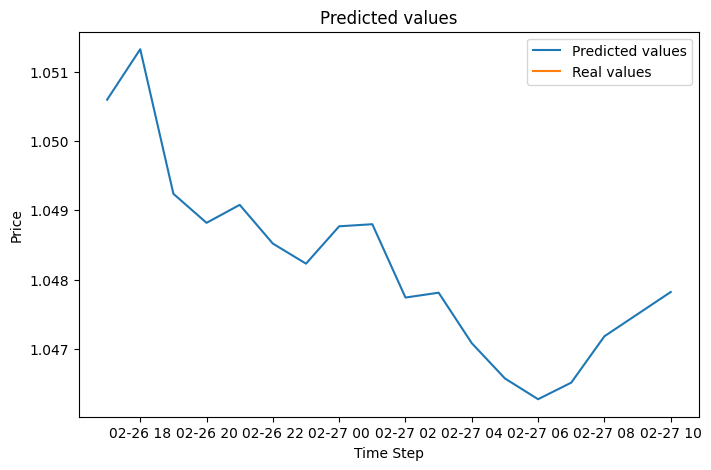

In [ ]:

# Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.plot(prev_ts[['CLOSE']].loc['2025-02-26 17:00:00':'2025-02-27 10:00:00'], label='Predicted values')
plt.plot(df[['OPEN']].loc['2025-02-26 17:00:00':'2025-03-04 10:00:00'], label='Real values')
plt.title('Predicted values')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
# df[['OPEN']].loc['2025-02-26 17:00:00+00:00':'2025-02-27 10:00:00+00:00']